In [5]:
import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [6]:
import os
os.makedirs("Masks", exist_ok=True)

In [7]:
def read_labelmap(path: str):
    mapper = {}
    labels = []
    with open(path, "r") as f:
        txt = f.read().split("\n")[1:-1]
        for i, cls in enumerate(txt):
            c = cls.split(":")
            label = c[0]
            color = tuple(map(int, c[1].split(",")))
            mapper[color] = i
            labels.append(label)
    return mapper, labels


def rgb_to_class(mask: np._typing.ArrayLike, mapper: dict[tuple, int]):
    mask_out = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int8)
    
    for cls_color in mapper:
        idx = mask == np.array(cls_color)
        validx = idx.sum(-1) == 3
        mask_out[validx] = mapper[cls_color]
    return mask_out

In [8]:
mapper, labels = read_labelmap("Annotations/labelmap.txt")

# Read data
with open("Annotations/ImageSets/Segmentation/PERIAPICALS.txt", "r") as f:
    names = f.read().split()
    names.remove("X18420_35")

images = [
    cv2.imread(f"Images/{name}.JPG", flags=cv2.IMREAD_GRAYSCALE)
    for name in tqdm(names, desc="Reading images", leave=True, position=0)
]
masks = [
    # rgb_to_class(cv2.cvtColor(cv2.imread(f"Annotations/SegmentationClass/{name}.png"), cv2.COLOR_BGR2RGB), mapper)
    np.load(f"Masks/{name}.npy")
    for name in tqdm(names, desc="Reading masks", leave=True, position=0)
]

Reading masks: 100%|██████████| 2158/2158 [00:00<00:00, 6322.66it/s]


In [9]:
import os
os.makedirs("Masks/", exist_ok=True)
for name, mask in zip(names, masks):
	np.save(f"Masks/{name}.npy", mask)

In [10]:
print(f"# Images: {len(images)}")
print(f"# Masks: {len(masks)}")

# Images: 2158
# Masks: 2158


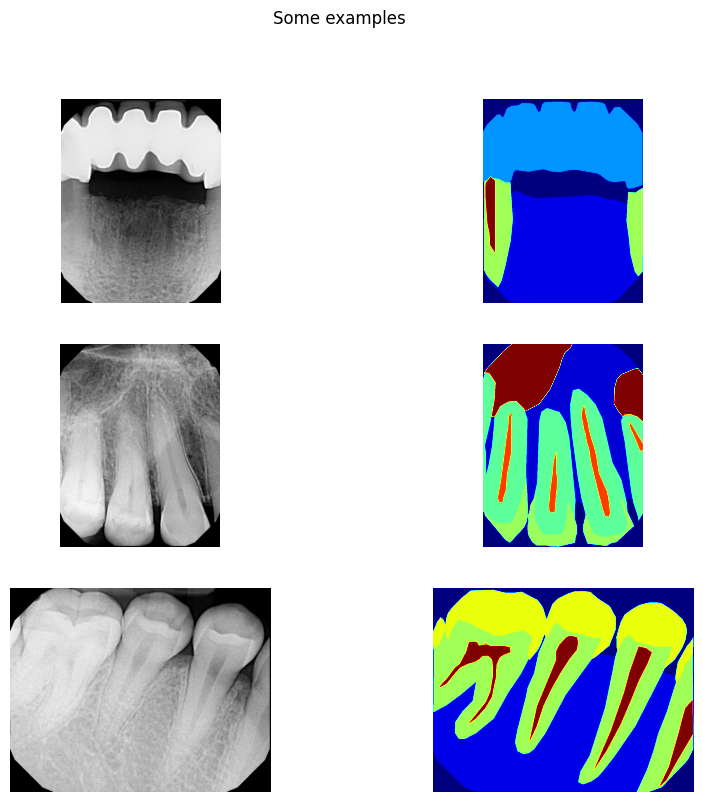

In [11]:
fig, ax = plt.subplots(3, 2, figsize=(10, 9))
fig.suptitle("Some examples")
for i, idx in enumerate(np.random.randint(0, len(images), 3)):
    ax[i, 0].imshow(images[idx], cmap="gray")
    ax[i, 1].imshow(masks[idx], cmap="jet")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

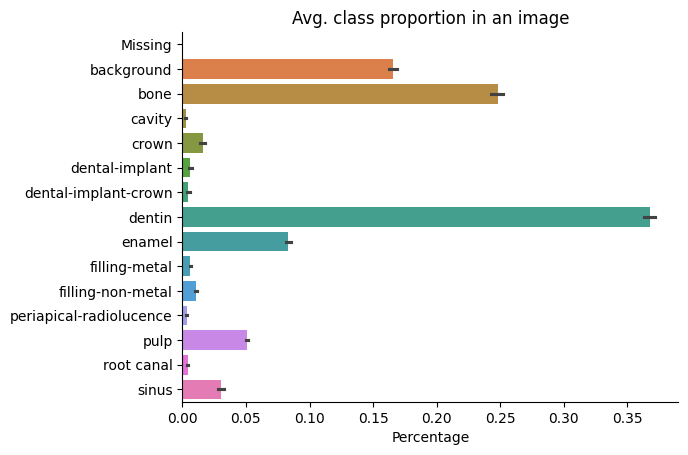

In [12]:
label_proportion = {label: [] for label in labels}

for (rgb, class_idx), label in zip(mapper.items(), labels):
    label_proportion[label].extend([
        np.count_nonzero(mask == class_idx) / mask.size
        for mask in masks
    ])

sns.barplot(pd.DataFrame(label_proportion), orient="h").set(
    title="Avg. class proportion in an image",
    xlabel="Percentage"
)
sns.despine()

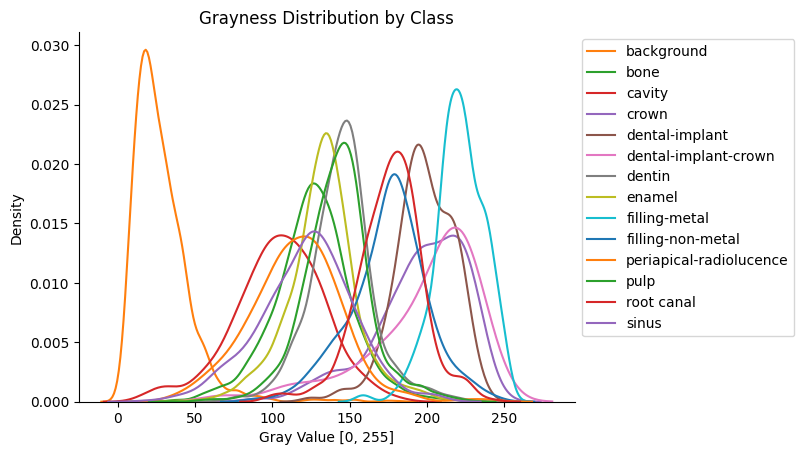

In [13]:
label_grayness = {label: [] for label in labels}

for (rgb, class_idx), label in zip(mapper.items(), labels):
    gray_values = []
    for i, (img, mask) in enumerate(zip(images, masks)):
        vals = img[mask == class_idx]
        if len(vals) > 0:
            gray_values.append(vals.mean())
    sns.kdeplot(gray_values, label=label)

plt.legend(bbox_to_anchor=(1, 1))
plt.title("Grayness Distribution by Class")
plt.xlabel("Gray Value [0, 255]")
sns.despine()

(np.float64(-0.5), np.float64(659.5), np.float64(843.5), np.float64(-0.5))

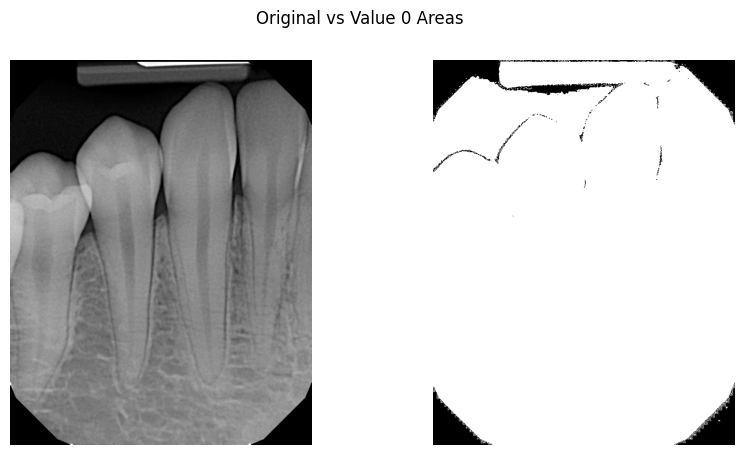

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
i = np.random.randint(0, len(images))

fig.suptitle("Original vs Value 0 Areas")
ax[0].imshow(images[i], cmap="gray")
ax[1].imshow(images[i] != 0, cmap="gray")
ax[0].axis("off")
ax[1].axis("off")

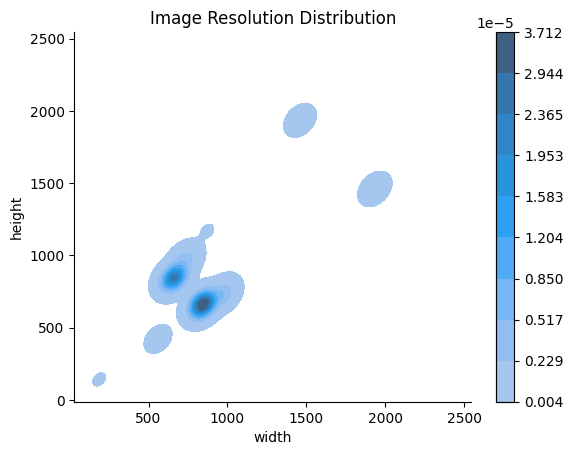

In [15]:
sizes = pd.DataFrame([
    img.shape[:2]
    for img in images
], columns=["height", "width"])
sns.kdeplot(sizes, x="width", y="height", fill=True, cbar=True, thresh=0.005).set(title="Image Resolution Distribution")
sns.despine()